# Visualizing Aggregated Analytics

We used spark to get the average velocity, average groupsize, and other nice analytics
from the Spark EMR cluster.

In [1]:
import pandas as pd
import numpy as np
import os

from bokeh.plotting import figure, show, output_file
from bokeh.models import ColumnDataSource, HoverTool

In [2]:
df = pd.read_csv('/Users/wfu/data/full_paired-10mins.csv')

In [3]:
df.columns

Index(['Unnamed: 0', 'window', 'sum(num_people)', 'sum(num_groups)',
       'sum(sum_velocities)', 'sum(num_velocities)', 'avg(num_people)',
       'x_centers', 'y_centers'],
      dtype='object')

In [4]:
df[:3]

,Unnamed: 0,window,sum(num_people),sum(num_groups),sum(sum_velocities),sum(num_velocities),avg(num_people),x_centers,y_centers
0,0,"Row(start=datetime.datetime(2019, 4, 10, 0, 20...",1,1,0.000000,0,0.001389,[0.449],[0.335]
1,1,"Row(start=datetime.datetime(2019, 4, 10, 0, 30...",7,7,0.014000,1,0.005833,"[0.709, 0.691, 0.718, 0.718, 0.455, 0.421, 0.812]","[0.339, 0.362, 0.459, 0.466, 0.731, 0.764, 0.56]"
2,2,"Row(start=datetime.datetime(2019, 4, 10, 0, 40...",66,36,0.714577,33,0.055000,"[0.694, 0.691, 0.693, 0.7, 0.688, 0.688, 0.685...","[0.334, 0.337, 0.331, 0.33, 0.334, 0.329, 0.33..."


Lets first plot the average velocity.
Currently the window is in the format of a string.
We want to make it in the units of datetime, where datetime
is when the windows starts.

In [5]:
df.window[0]

'Row(start=datetime.datetime(2019, 4, 10, 0, 20), end=datetime.datetime(2019, 4, 10, 0, 30))'

Let's take off the row and the parens, and `start=` and `end=`.

In [6]:
start, end = df.window[0][4:-1].replace('start=', '').replace('end=', '').split(', datetime.')
start = start.replace("datetime.", "")
end = end.replace('datetime.', '')
print(start)
print(end)

datetime(2019, 4, 10, 0, 20)
datetime(2019, 4, 10, 0, 30)


In [7]:
from datetime import datetime
def filter_window_row(row):
    start, end = row[4:-1].replace('start=', '').replace('end=', '').split(', datetime.')
    start = start.replace("datetime.", "")
    end = end.replace('datetime.', '')
    return eval(start)

In [8]:
df['start'] = df.window.map(filter_window_row)
df['start_string'] = df['start'].map(lambda timestamp: timestamp.strftime("%b %d %Y %H:%M:%S %p"))
df.index.name = 'index'

In [9]:
df[:3]

,Unnamed: 0,window,sum(num_people),sum(num_groups),sum(sum_velocities),sum(num_velocities),avg(num_people),x_centers,y_centers,start,start_string
index,,,,,,,,,,,
0,0,"Row(start=datetime.datetime(2019, 4, 10, 0, 20...",1,1,0.000000,0,0.001389,[0.449],[0.335],2019-04-10 00:20:00,Apr 10 2019 00:20:00 AM
1,1,"Row(start=datetime.datetime(2019, 4, 10, 0, 30...",7,7,0.014000,1,0.005833,"[0.709, 0.691, 0.718, 0.718, 0.455, 0.421, 0.812]","[0.339, 0.362, 0.459, 0.466, 0.731, 0.764, 0.56]",2019-04-10 00:30:00,Apr 10 2019 00:30:00 AM
2,2,"Row(start=datetime.datetime(2019, 4, 10, 0, 40...",66,36,0.714577,33,0.055000,"[0.694, 0.691, 0.693, 0.7, 0.688, 0.688, 0.685...","[0.334, 0.337, 0.331, 0.33, 0.334, 0.329, 0.33...",2019-04-10 00:40:00,Apr 10 2019 00:40:00 AM


These are now string with the datetime object.

In [10]:
HEIGHT = 360
WIDTH = 640

In [11]:
# Bokeh Library
from bokeh.io import output_file, output_notebook
from bokeh.models.widgets import Tabs, Panel
from bokeh.plotting import show

# Output to file
# output_notebook()

In [12]:
filtered_df = df.drop(columns=["x_centers", "y_centers"])

In [13]:
filtered_df.columns

Index(['Unnamed: 0', 'window', 'sum(num_people)', 'sum(num_groups)',
       'sum(sum_velocities)', 'sum(num_velocities)', 'avg(num_people)',
       'start', 'start_string'],
      dtype='object')

In [14]:
filtered_df.columns = ["index", "window", "sum_num_people", "sum_num_groups", "sum_sum_velocities", 
                       "sum_num_velocities", "avg_num_people", "start", "start_string"]

In [15]:
def average_velocity(row):
    try:
        return row['sum_sum_velocities'] / row['sum_num_velocities']
    except ZeroDivisionError:
        return 0

filtered_df['avg_velocity'] = filtered_df.apply(average_velocity, axis=1)
filtered_df

,index,window,sum_num_people,sum_num_groups,sum_sum_velocities,sum_num_velocities,avg_num_people,start,start_string,avg_velocity
index,,,,,,,,,,
0,0,"Row(start=datetime.datetime(2019, 4, 10, 0, 20...",1,1,0.000000,0,0.001389,2019-04-10 00:20:00,Apr 10 2019 00:20:00 AM,0.000000
1,1,"Row(start=datetime.datetime(2019, 4, 10, 0, 30...",7,7,0.014000,1,0.005833,2019-04-10 00:30:00,Apr 10 2019 00:30:00 AM,0.014000
2,2,"Row(start=datetime.datetime(2019, 4, 10, 0, 40...",66,36,0.714577,33,0.055000,2019-04-10 00:40:00,Apr 10 2019 00:40:00 AM,0.021654
3,3,"Row(start=datetime.datetime(2019, 4, 10, 0, 50...",40,35,0.181781,15,0.033333,2019-04-10 00:50:00,Apr 10 2019 00:50:00 AM,0.012119
4,4,"Row(start=datetime.datetime(2019, 4, 10, 1, 0)...",106,56,1.592606,66,0.088333,2019-04-10 01:00:00,Apr 10 2019 01:00:00 AM,0.024130
5,5,"Row(start=datetime.datetime(2019, 4, 10, 1, 10...",1,1,0.000000,0,0.000833,2019-04-10 01:10:00,Apr 10 2019 01:10:00 AM,0.000000
6,6,"Row(start=datetime.datetime(2019, 4, 10, 1, 20...",13,12,0.029189,4,0.010934,2019-04-10 01:20:00,Apr 10 2019 01:20:00 AM,0.007297
7,7,"Row(start=datetime.datetime(2019, 4, 10, 1, 30...",20,16,0.146305,11,0.016667,2019-04-10 01:30:00,Apr 10 2019 01:30:00 AM,0.013300
8,8,"Row(start=datetime.datetime(2019, 4, 10, 1, 40...",101,66,1.216250,59,0.084167,2019-04-10 01:40:00,Apr 10 2019 01:40:00 AM,0.020614


In [16]:
filtered_df['avg_group_size'] = 1. * filtered_df['sum_num_people'] / filtered_df['sum_num_groups']

In [17]:
hover = HoverTool()
hover.tooltips = [('Timestamp', '@start_string'),
                  ('Average Number of People', '@avg_num_people)'),]

num_people_graph = figure(title="Number of People in Science Center Plaza",
    plot_height=500, 
    plot_width=900,
    # y_range=(0, 20),
    match_aspect=True,
    tools=[hover, "pan,reset,wheel_zoom"])

num_people_graph.vbar(x='index',
       top='avg_num_people',
       width=0.9,
       color='red',
       source=ColumnDataSource(filtered_df))

num_people_graph.xaxis.axis_label = "Time Window (Hover for Timestamp)"
num_people_graph.yaxis.axis_label = "Average Number of People in Camera"

hover.tooltips = [('Timestamp', '@start_string'),
                  ('Average Velocity', '@avg_velocity)'),]

avg_velocity_graph = figure(title="Average Velocity",
    plot_height=500, 
    plot_width=900,
    match_aspect=True,
    y_range=(0, 1),
    tools=[hover, "pan,reset,wheel_zoom"])

avg_velocity_graph.vbar(x='index',
       top='avg_velocity',
       width=0.9,
       color='blue',
       source=ColumnDataSource(filtered_df))

hover.tooltips = [('Timestamp', '@start_string'),
                  ('Average Group Size', '@avg_group_size)'),]

avg_group_size_graph = figure(title="Average Group Size",
    plot_height=500, 
    plot_width=900,
    match_aspect=True,
    y_range=(0, 4),
    tools=[hover, "pan,reset,wheel_zoom"])

avg_group_size_graph.vbar(x='index',
       top='avg_group_size',
       width=0.9,
       color='green',
       source=ColumnDataSource(filtered_df))


panel1 = Panel(child=num_people_graph, title='Average Number of People')
panel2 = Panel(child=avg_velocity_graph, title='Average Velocity')
panel3 = Panel(child=avg_group_size_graph, title='Average Group Size')

# Assign the panels to Tabs
tabs = Tabs(tabs=[panel1, panel2, panel3])

In [18]:
show(tabs)

## Making the Heatmap Over Time

Now, we make the heatmap over time.
We couldn't just display the heatmap for the interactive graph because there is too much data,
on the order of 150 MB.
This would essentially be too much work for the browser on my computer.
Therefore, I will render these visualizations into a video.

In [19]:
df[:1]

,Unnamed: 0,window,sum(num_people),sum(num_groups),sum(sum_velocities),sum(num_velocities),avg(num_people),x_centers,y_centers,start,start_string
index,,,,,,,,,,,
0,0,"Row(start=datetime.datetime(2019, 4, 10, 0, 20...",1,1,0.0,0,0.001389,[0.449],[0.335],2019-04-10 00:20:00,Apr 10 2019 00:20:00 AM


For each window, we see that the centers show up as a list.
Let's try just plotting one of these rows and making a heatmap.
We may also have to batch some of these together for a larger aggregate, or else there might not be enough data.

In [20]:
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import cv2
import copy

# Make the color stuff with alpha on top of it
red_alpha = copy.copy(matplotlib.cm.Reds)
blue_alpha = copy.copy(matplotlib.cm.Blues)
green_alpha = copy.copy(matplotlib.cm.Greens)
red_alpha._init()
blue_alpha._init()
green_alpha._init()
red_alpha._lut[0,3] = 0
blue_alpha._lut[0,3] = 0
green_alpha._lut[0,3] = 0

In [21]:
def get_range_of_locations(start, end):
    """gets all the bounding box centers from entry `start` to entry `end`
    of our dataframe. returns it as two lists."""
    data_x, data_y = [], []
    for index in range(start, end):
        test_row = df.iloc[index]
        data_x += list(eval(test_row['x_centers']))
        data_y += list(eval(test_row['y_centers']))
    return np.array(data_x), np.array(data_y)

In [22]:
test_row = df.iloc[300]
# print(test_row)
test_x, test_y = np.array(eval(test_row['x_centers'])), np.array(eval(test_row['y_centers']))

In [23]:
print("Number of detections in this window: %d" % len(test_x))

Number of detections in this window: 173


In [24]:
WIDTH = 640
HEIGHT = 360

In [39]:
matplotlib.rcParams['font.size'] = 16
def heatmap_between_ranges(start, end, save_path=None, background=False):
    """Generate heatmap from entry `start` to entry `end`
    of our dataframe."""
    fig, ax = plt.subplots(figsize=(16, 9))
    if background:
        image = cv2.imread("/Users/wfu/Desktop/llorente.png")
        ax.imshow(image, origin='lower')
    picture_range = np.array([[0, 640], [0, 360]])
    data_x, data_y = get_range_of_locations(start, end)
    start_date = df.iloc[start]['start_string']

    data_x *= WIDTH
    data_y *= HEIGHT
    ax.set_title(start_date)
    alpha = 0.6 if background else 1.
    norm = matplotlib.colors.Normalize(vmin=0, vmax=200)
    ax.hist2d(data_x, data_y, range=picture_range, bins=(160, 90), cmap=red_alpha, alpha=alpha, norm=norm)
    plt.axis('equal')
    plt.axis('off')
    ax.invert_yaxis()
    if save_path:
        # Save it to whatever save path name we give it.
        fig.savefig(save_path)
        plt.close()
    else:
        plt.show()

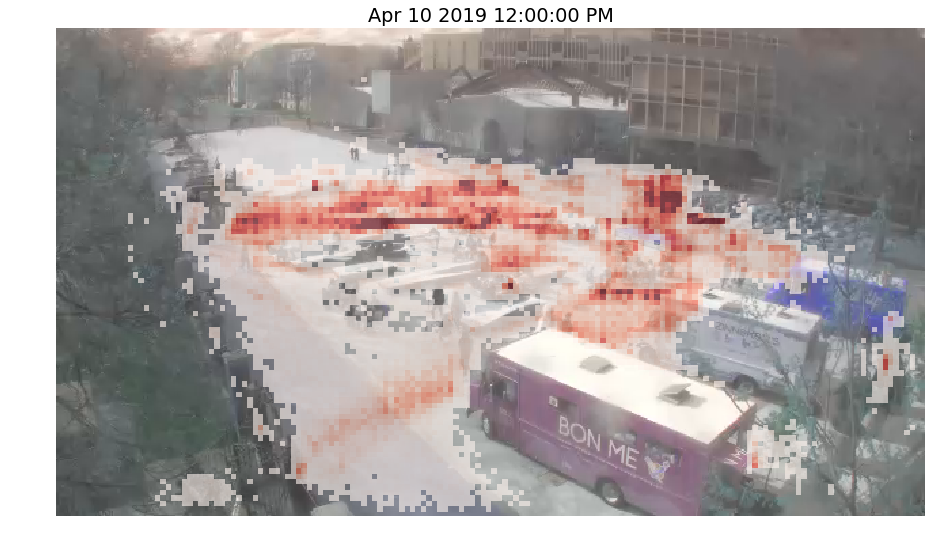

In [40]:
heatmap_between_ranges(70, 80, background=True)

In [41]:
import tqdm
counter = 0
FIG_SAVE_PATH = "/tmp/heatmap%06d.png"
for i in tqdm.tqdm(range(50, 120)):
    fname = FIG_SAVE_PATH % counter
    heatmap_between_ranges(i, i+4, save_path=fname, background=True)
    counter += 1

100%|██████████| 70/70 [00:34<00:00,  3.05it/s]


In [42]:
%%bash
ffmpeg -framerate 2 -y -i /tmp/heatmap%06d.png heatmap.mp4

ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, image2, from '/tmp/heatmap%06d.png':
  Duration: 00:00:35.00, start: 0.000000, bitrate: N/A
    Stream #0:0: Video: png, rgba(pc), 1152x648 [SAR 2834:2834 DAR 16:9], 2 fps, 2 tbr, 